# Introduction

In this notebook, we present the implementation and the empirical study of 'L-SAGA' : our proposed learning hyper-heuristic for the flowhsop permutation problem (FPP). It uses a simulated annealing algorithm for the top level equipped with a novel add-on learning component, and an adaptation of the genetic algorithm for the FPP for the bottom level.

The implementation code is first presented, then tested on each of the taillard instances benchmark.The obtained make-spans are compared with those of our implementation of the genetic algorithm for flowhsop, simulated annealing, and the 3 dedicated heuristics of Palmer, CDS and NEH.

Dependencies

In [8]:
import numpy as np
import pandas as pd
import optuna
import copy
import random
import math
import heuristics
import importlib
from tqdm import tqdm
from matplotlib import pyplot as plt

d:\ycondabase\envs\aivenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Class to hold a taillard instance

In [9]:
class Inst:
    def __init__(self, jobs: int, machines: int, seed: int, ub: int, lb: int, matrix: list[list[int]]):
        """
        Represents an instance of the scheduling problem.
        
        Args:
            jobs (int): Number of jobs.
            machines (int): Number of machines.
            seed (int): Seed for random number generation.
            ub (int): Upper bound.
            lb (int): Lower bound.
            matrix (list[list[int]]): Matrix representing job durations on machines.
        """
        self.jobs = jobs
        self.machines = machines
        self.seed = seed
        self.ub = ub
        self.lb = lb
        self.matrix = matrix

Function to load the instances of a taillard configuration

In [10]:
def load_tai(nb_jobs, nb_machines):
    with open(f"content/tai{nb_jobs}_{nb_machines}.txt", "r") as f:
        lines = f.readlines()

    instances: list[Inst] = []
    i = 0
    while i < len(lines):
        params = [int(e) for e in lines[i+1].split()]
        jobs = params[0]
        machines = params[1]
        seed = params[2]
        ub = params[3]
        lb = params[4]

        matrix = [[int(e) for e in line.strip().split()] for line in lines[i+3:i+3+machines]]
        instances.append(Inst(jobs, machines, seed, ub, lb, matrix))
        i+=3+machines
    
    return instances

Podium Bank data structure

In [11]:
class PodiumBank:
    def __init__(self, size=10):
        #the bank is sorted in an ascendant manner of the make span
        self.bank = list()
        self.size = size

    
    def insert(self, ms_hps): #make_span hyper_parameter_state tuple
        if len(self.bank) == 0:
            self.bank.append(ms_hps)
        else:
            insertion_index = -1
            for i in range(len(self.bank)):
                if ms_hps[0]<self.bank[i][0]:
                    insertion_index = i
            if insertion_index != -1:
                self.bank = self.bank[:i] + [ms_hps] + self.bank[i:self.size-1]        

In [12]:
set([1,2,3,4]).discard(4)

In [13]:
d = {1:2, 3:4, 5:6}
d[0] = 8
d.keys()

dict_keys([1, 3, 5, 0])

In [14]:
nb_jobs = 20
k_mms = (0.01, 0.1, 0.01)
k_values = [int(nb_jobs * (k_mms[0]+i*k_mms[2])) for i in range(int((k_mms[1]-k_mms[0])/k_mms[2])+1)]
list(set(k_values))

[0, 1]

In [38]:
class LSAGA:
    def __init__(self,
                 tai_inst:Inst,
                 init_type=['cds', 'palmer', 'neh', 'heuristics', 'heuristics_random', 'full_random'],
                 selection_type=['roulette', 'rank', 'elitist', 'tournament', 'random'],
                 crossover_type=['uniform', 'k_points'],
                 replacement_type=['best_all', 'parents_replaced_by_offspring', 'worst_population_replaced_by_offspring', 'best_between_parents_and_offspring', 'roulette', 'rank', 'elitist', 'tournament', 'random'],
                 population_size_mms=(20,50,5), #min_max_step
                 pool_size_mms=(0.1, 0.9, 0.1),
                 crossover_rate_mms=(0.1, 0.9, 0.1),
                 mutation_rate_mms=(0.1, 0.9, 0.1),
                 num_iterations_mms=(200, 600, 100),
                 max_stagnation_mms=(50, 200, 50),
                 k_points_mms=(0.1, 0.9, 0.1),
                 variety_degree=1,
                 num_hyper_params_neigh_window=1, #numeric hyper-parameters neighboring window size
                 cat_neigh_ratio=0.4,
                 podium_banck_size=10
                ):
        self.tai_inst = tai_inst
        self.jobs_list = self.get_instance(tai_inst)
        self.nb_jobs = len(self.jobs_list)
        self.nb_machines = len(self.jobs_list[0])
        self.hps_star = None
        self.seq_star = None
        self.make_span_star = None
        self.hyper_params = {
            'init_type': init_type,
            'selection_type': selection_type,
            'crossover_type': crossover_type,
            'replacement_type': replacement_type,
            'population_size': [i for i in range(population_size_mms[0], population_size_mms[1]+1, population_size_mms[2])],
            'pool_size': [pool_size_mms[0]+i*pool_size_mms[2] for i in range(int((pool_size_mms[1]-pool_size_mms[0])/pool_size_mms[2])+1)],
            'crossover_rate': [crossover_rate_mms[0]+crossover_rate_mms[2]*i for i in range(int((crossover_rate_mms[1]-crossover_rate_mms[0])/crossover_rate_mms[2])+1)],
            'mutation_rate': [mutation_rate_mms[0]+mutation_rate_mms[2]*i for i in range(int((mutation_rate_mms[1]-mutation_rate_mms[0])/mutation_rate_mms[2])+1)],
            'num_iterations': [i for i in range(num_iterations_mms[0], num_iterations_mms[1]+1, num_iterations_mms[2])],
            'max_stagnation': [i for i in range(max_stagnation_mms[0],max_stagnation_mms[1]+1,max_stagnation_mms[2])],
        }
        s = set(
                [int((self.nb_jobs-1) * (0.01+i*0.01)) for i in range(10)]+ #exploring the hundredths
                [int((self.nb_jobs-1) * (k_points_mms[0]+i*k_points_mms[2])) for i in range(int((k_points_mms[1]-k_points_mms[0])/k_points_mms[2])+1)] #exploruing above tenths
            )
        s.discard(0)
        self.hyper_params['k_points'] =  list(s)
        self.cat_hyper_params = ['init_type', 'selection_type', 'crossover_type', 'replacement_type']
        self.num_hyper_params = ['population_size', 'pool_size', 'crossover_rate', 'mutation_rate', 'num_iterations', 'max_stagnation', 'k_points']
        self.variable_params = [key for key in self.hyper_params.keys() if self.hyper_params[key][0] != self.hyper_params[key][-1]]
        if variety_degree > len(self.variable_params): raise Exception("variety_degree > len(self.variable_params)")
        self.variety_degree = variety_degree
        self.num_hyper_params_neigh_window = num_hyper_params_neigh_window
        self.cat_neigh_ratio = cat_neigh_ratio
        self.podium_bank = PodiumBank(size=podium_banck_size)
        self.neh_res = heuristics.NEH(self.tai_inst)()
        self.cds_res = heuristics.cds_heuristic(np.array(self.jobs_list))
        self.palmer_res = heuristics.Palmer(self.jobs_list).optim()

        #stats
        self.nb_podium_bank_usage = 0
        self.nb_deteriorations = 0
        self.nb_jumps = 0
        self.hps_star_trace = []
        self.current_make_span_trace = []


    # utility functions for the low level genetic algorithm

    def get_instance(self, tai_inst: Inst):
        # Extract the jobs list from the given instance
        
        jobs_list = []
        for i in range(len(tai_inst.matrix[0])):
            jobs_list.append([])
            for j in range(len(tai_inst.matrix)):
                jobs_list[-1].append(tai_inst.matrix[j][i])
        return jobs_list

    def cumulate(self, job: list, previous_cumul=None):
        # Calculate the cumulative completion times for a job
        
        res = [0] * len(job)
        if previous_cumul == None:
            res[0] = job[0]
            for i in range(1, len(job)):
                res[i] = res[i - 1] + job[i]
        else:
            res[0] = previous_cumul[0] + job[0]
            for i in range(1, len(job)):
                res[i] = max(res[i - 1], previous_cumul[i]) + job[i]
        return res

    def cumulate_seq(self, seq: list):
        # Calculates the cumulative time for a sequence of jobs on machines.

        cumulated = None
        for i in seq:
            cumulated = self.cumulate(self.jobs_list[i], cumulated)
        return cumulated

    def evaluate_makespan(self, schedule):
        # Evaluates the makespan (completion time) of a given schedule.

        cumulative = self.cumulate_seq(schedule)
        return cumulative[-1]
 
    def initialize_population(self, init_type, population_size):
        """
        Initializes the population of individuals.
        
        Args:
            init_type (str): Type of initialization method.
            population_size (int): Size of the population.
            
        Returns:
            list: Initialized population of individuals.
        """
        
        def perturb_sequence(sequence):
            """
            Perturbs a sequence by swapping two random jobs.
            
            Args:
                sequence (list): Sequence of jobs.
                
            Returns:
                list: Perturbed sequence.
            """
            perturbed_seq = sequence[:]
            for _ in range(2):
                i, j = random.sample(range(len(perturbed_seq)), 2)
                perturbed_seq[i], perturbed_seq[j] = perturbed_seq[j], perturbed_seq[i]
            return perturbed_seq

        population = []
        
        if init_type == "cds":
            cds_seq, _ = self.cds_res#heuristics.cds_resheuristic(np.array(self.jobs_list))
            population.append(cds_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(cds_seq)
                population.append(perturbed_seq)

        elif init_type == "palmer":
            palmer_seq, _ = self.palmer_res#heuristics.Palmer(self.jobs_list).optim()
            population.append(palmer_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(palmer_seq)
                population.append(perturbed_seq)

        elif init_type == "neh":
            _, neh_seq = self.neh_res#heuristics.NEH(self.tai_inst)()
            population.append(neh_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(neh_seq)
                population.append(perturbed_seq)

        elif init_type == "heuristics":
            cds_size = population_size // 3
            palmer_size = population_size // 3
            neh_size = population_size - cds_size - palmer_size
            
            for _ in range(cds_size):
                cds_seq, _ = self.cds_res#heuristics.cds_heuristic(np.array(self.jobs_list))
                population.append(perturb_sequence(cds_seq))
            
            for _ in range(palmer_size):
                palmer_seq, _ = self.palmer_res#heuristics.Palmer(self.jobs_list).optim()
                population.append(perturb_sequence(palmer_seq))
            
            for _ in range(neh_size):
                _, neh_seq = self.neh_res#heuristics.NEH(self.tai_inst)()
                population.append(perturb_sequence(neh_seq))

        elif init_type == "heuristics_random":

            cds_seq, _ = self.cds_res#heuristics.cds_heuristic(np.array(self.jobs_list))
            population.append(perturb_sequence(cds_seq))

            palmer_seq, _ = self.palmer_res#heuristics.Palmer(self.jobs_list).optim()
            population.append(perturb_sequence(palmer_seq))

            _, neh_seq = self.neh_res#heuristics.NEH(self.tai_inst)()
            population.append(perturb_sequence(neh_seq))

            for _ in range(population_size - 3):
                random_seq = random.sample(range(self.nb_jobs), self.nb_jobs)
                population.append(random_seq)

        elif init_type == "full_random":

            for _ in range(population_size):
                random_seq = random.sample(range(self.nb_jobs), self.nb_jobs)
                population.append(random_seq)

        else:
            raise ValueError("Invalid initialization type")

        return population
  
    def select_parents(self, population):
        """
        Selects parents from the population using tournament selection.
        
        Args:
            population (list): Population of individuals.
            
        Returns:
            tuple: Pair of selected parents.
        """
        tournament = random.sample(population, 3)
        tournament.sort(key=lambda x: self.evaluate_makespan(x))
        return tournament[0], tournament[1]
  
    def crossover(self, crossover_type, parent1, parent2, crossover_rate, k_points=None):
        """
        Performs crossover between two parents to produce offspring.
        
        Args:
            crossover_type (str): Type of crossover operation.
            parent1 (list): First parent.
            parent2 (list): Second parent.
            crossover_rate (float): Rate of crossover.
            k (int, optional): Parameter for k-point crossover. Defaults to None.
            
        Returns:
            tuple: Pair of offspring.
        """

        def ensure_each_job_once(offspring):
            """
            Ensures each job appears exactly once in the offspring.
            
            Args:
                offspring (list): Offspring sequence.
            """
            # Ensure offspring contains each job exactly once
            job_count = {job: 0 for job in range(self.nb_jobs)}
            for job in offspring:
                job_count[job] += 1
            for i, job in enumerate(offspring):
                if job_count[job] > 1:
                    for swap_job, count in job_count.items():
                        if count == 0:
                            offspring[i] = swap_job
                            job_count[swap_job] += 1
                            job_count[job] -= 1
                            break

        if random.random() < crossover_rate:
            
            if crossover_type == 'uniform':
                k = None
                mask = [random.choice([0, 1]) for _ in range(len(parent1))]
                offspring1 = [gene1 if bit else gene2 for gene1, gene2, bit in zip(parent1, parent2, mask)]
                offspring2 = [gene1 if bit else gene2 for gene1, gene2, bit in zip(parent2, parent1, mask)]

            else:
                if k_points is None or k_points < 1:
                    raise ValueError("k must be >= 1 for one_point, two_points, and k_points crossovers")
                
                if k_points is not None and k_points >= self.nb_jobs:
                    raise ValueError("k in crossover must be less than the number of jobs")

                if ((crossover_type == 'one_point') or (k_points == 1)):
                    k = 1
                    points = [random.randint(1, len(parent1) - 1)]

                elif ((crossover_type == 'two_points') or (k_points == 2)):
                    k = 2
                    points = sorted(random.sample(range(1, len(parent1)), 2))

                elif crossover_type == 'k_points':
                    points = sorted(random.sample(range(1, len(parent1)), k_points))

                else:
                    raise ValueError("Invalid crossover type")

                offspring1, offspring2 = parent1[:], parent2[:]
                switch = False
                for i in range(len(parent1)):
                    if i in points:
                        switch = not switch
                    if switch:
                        offspring1[i], offspring2[i] = offspring2[i], offspring1[i]

            ensure_each_job_once(offspring1)
            ensure_each_job_once(offspring2)
            return offspring1, offspring2
        
        else:
            return parent1[:], parent2[:]

    def mutate(self, solution, mutation_rate):
        """
        Mutates a solution with a given mutation rate.
        
        Args:
            solution (list): Solution to mutate.
            mutation_rate (float): Rate of mutation.
            
        Returns:
            list: Mutated solution.
        """
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(solution)), 2)
            solution[i], solution[j] = solution[j], solution[i]
        return solution

    def select_reproduction_pool(self, selection_type, population, pool_size):
        """
        Selects a pool of individuals for reproduction.
        
        Args:
            selection_type (str): Type of selection method.
            population (list): Population of individuals.
            pool_size (int): Size of the pool.
            
        Returns:
            list: Pool of selected individuals.
        """
        
        chosen = []

        if selection_type == "roulette":
            total_fitness = sum(self.evaluate_makespan(ind) for ind in population)
            selection_probs = [self.evaluate_makespan(ind) / total_fitness for ind in population]
            chosen = random.choices(population, weights=selection_probs, k=pool_size)

        elif selection_type == "rank":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            ranks = range(1, len(population_sorted) + 1)
            total_rank = sum(ranks)
            rank_weights = [rank / total_rank for rank in ranks]
            chosen = random.choices(population_sorted, weights=rank_weights, k=pool_size)

        elif selection_type == "elitist":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            chosen = population_sorted[:pool_size]

        elif selection_type == "tournament":
            for _ in range(pool_size):
                contenders = random.sample(population, 3)
                chosen.append(min(contenders, key=self.evaluate_makespan))

        elif selection_type == "random":
            chosen = random.sample(population, pool_size)
            
        else:
            raise ValueError("Invalid type")

        return chosen
  
    def replace_population(self, replacement_type, population, parents, offspring, population_size):
        """
        Replaces the population with new individuals.
        
        Args:
            replacement_type (str): Type of replacement method.
            population (list): Current population.
            parents (list): Parents generated during reproduction.
            offspring (list): Offspring generated during reproduction.
            population_size (int): Size of the population.
            
        Returns:
            list: New population.
        """
        
        def select_population(selection_type, population, pool_size):
            """
            Selects individuals for the next population.
            
            Args:
                selection_type (str): Type of selection method.
                population (list): Population of individuals.
                pool_size (int): Size of the selection pool.
                
            Returns:
                list: Selected individuals for the next population.
            """
            return self.select_reproduction_pool(selection_type, population, pool_size)

        if replacement_type == "best_all":
            combined_population = population + offspring
            combined_population.sort(key=lambda x: self.evaluate_makespan(x))
            return combined_population[:population_size]

        elif replacement_type == "parents_replaced_by_offspring":
            population_without_parents = [ind for ind in population if ind not in parents]
            return population_without_parents + offspring

        elif replacement_type == "worst_population_replaced_by_offspring":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            population_without_worst = population_sorted[:-len(offspring)]
            return population_without_worst + offspring

        elif replacement_type == "best_between_parents_and_offspring":
            population_without_parents = [ind for ind in population if ind not in parents]
            combined_sub_population = sorted(parents + offspring, key=self.evaluate_makespan)
            return population_without_parents + combined_sub_population[:len(parents)]
        
        else:
            return select_population(replacement_type, population + offspring, len(population))

    def genetic_algorithm(self, init_type, selection_type, crossover_type, replacement_type, population_size, pool_size, crossover_rate, mutation_rate, num_iterations, max_stagnation, k_points=None):
        """
        Executes the Genetic Algorithm to find the best solution.
        
        Args:
            init_type (str): Type of initialization method.
            selection_type (str): Type of parent selection method.
            crossover_type (str): Type of crossover method.
            replacement_type (str): Type of population replacement method.
            population_size (int): Size of the population.
            pool_size (int): Size of the reproduction pool.
            crossover_rate (float): Rate of crossover.
            mutation_rate (float): Rate of mutation.
            num_iterations (int): Maximum number of iterations.
            max_stagnation (int): Maximum number of iterations without improvement.
            k_points (int, optional): Parameter for k-point crossover. Defaults to None.
            
        Returns:
            tuple: Best solution and its makespan.
        """
        
        if pool_size > population_size:
            raise ValueError("Pool size must be less than population size.")

        population = self.initialize_population(init_type, population_size)
        population.sort(key=lambda x: self.evaluate_makespan(x))
        
        best_solution = population[0]
        best_solution_fitness = self.evaluate_makespan(best_solution)
        stagnation_count = 0

        for i in range(num_iterations):
            reproduction_pool = self.select_reproduction_pool(selection_type, population, pool_size)
            offspring = []
            parents = []

            for _ in range(pool_size // 2):
                parent1, parent2 = self.select_parents(reproduction_pool)
                parents.extend([parent1, parent2])
                child1, child2 = self.crossover(crossover_type, parent1, parent2, crossover_rate, k_points) 
                child1 = self.mutate(child1, mutation_rate)
                child2 = self.mutate(child2, mutation_rate)
                offspring.extend([child1, child2])

            population = self.replace_population(replacement_type, population, parents, offspring, population_size)
            population.sort(key=lambda x: self.evaluate_makespan(x))

            current_best_solution = population[0]
            current_best_solution_fitness = self.evaluate_makespan(current_best_solution)

            if current_best_solution_fitness < best_solution_fitness:
                best_solution = current_best_solution
                best_solution_fitness = current_best_solution_fitness
                stagnation_count = 0
            else:
                stagnation_count += 1

            if max_stagnation is not None and stagnation_count >= max_stagnation:
                break

        return best_solution

    # utility functions for the high level simulated annealing

    def init_random_hps(self):
        hps={
            'init_type':np.random.choice(self.hyper_params['init_type']),
            'selection_type':np.random.choice(self.hyper_params['selection_type']),
            'crossover_type':np.random.choice(self.hyper_params['crossover_type']),
            'replacement_type':np.random.choice(self.hyper_params['replacement_type']),
            'population_size':np.random.choice(self.hyper_params['population_size']),
            'pool_size':np.random.choice(self.hyper_params['pool_size']),
            'crossover_rate':np.random.choice(self.hyper_params['crossover_rate']),
            'mutation_rate':np.random.choice(self.hyper_params['mutation_rate']),
            'num_iterations':np.random.choice(self.hyper_params['num_iterations']),
            'max_stagnation':np.random.choice(self.hyper_params['max_stagnation']),
            'k_points':np.random.choice(self.hyper_params['k_points'])
        }
        return hps
    
    def cartesian_product(self, possible_values, keys): #the list of possible values for each dimension
        products = [{keys[0]:value} for value in possible_values[0]]
        for dimension_values, key in zip(possible_values[1:], keys[1:]):    
            new_products = []
            for product in products:
                for value in dimension_values:
                    new_product = dict(product)
                    new_product[key] = value
                    new_products.append(new_product)
            products = new_products
        return products

    def measure_hps_dist(self, hps1, hps2):
        dist = 0
        for hyper_param in self.cat_hyper_params:
            dist +=  (1 if hps1[hyper_param] == hps2[hyper_param] else 0) # * relevance_coeff ...! 
        for hyper_param in self.num_hyper_params:
            if hyper_param not in self.variable_params: continue
            dist += abs(hps1[hyper_param] - hps2[hyper_param]) / (self.hyper_params[hyper_param][-1] - self.hyper_params[hyper_param][0]) # * relevance_coeff ...!
        return dist

    def get_podium_score(self,neigh):
        score = 0
        tot_podium_make_spans = sum([1/(ms_champion[0]) for ms_champion in self.podium_bank.bank])
        for make_span, champion in self.podium_bank.bank:
            score += math.exp(-self.measure_hps_dist(neigh, champion)) * ((1/(make_span))/tot_podium_make_spans)
        return score

    def generate_neigh_hps(self, hps, T, beta):
        #randomly selecting 'self.variety_degree' hyper_parameters to forcibly vary, the rest of the hyper_params can either vary or not
        varied_keys = np.random.choice([key for key in self.variable_params], self.variety_degree, replace=False)
        #we create the neighbor hps possible values for each hyper parameter
        neigh_hps_values = []
        #for each categorical hyper-param
        for hyper_param in self.cat_hyper_params:
            #if the hyper param is to be forcibly varied
            if hyper_param in varied_keys:
                neigh_space = list(self.hyper_params[hyper_param])
                neigh_space.remove(hps[hyper_param])
                neigh_hps_values.append(np.random.choice(neigh_space, int(self.cat_neigh_ratio * len(neigh_space)+1), replace=False))
            else:
                neigh_hps_values.append(np.random.choice(self.hyper_params[hyper_param], int(self.cat_neigh_ratio * len(self.hyper_params[hyper_param]))+1, replace=False))
        #for each numercial hyper-param
        for hyper_param in self.num_hyper_params:
            # we get its index in the range of possible values
            hyper_param_value_index = self.hyper_params[hyper_param].index(hps[hyper_param])
            # we get the bottom index of the neighboring window using self.num_hyper_param_neigh_windows
            win_bottom_index = hyper_param_value_index-self.num_hyper_params_neigh_window
            # we check if we didn't go below 0
            if win_bottom_index < 0: win_bottom_index = 0
            # we create the neighboring space
            neigh_space = self.hyper_params[hyper_param][win_bottom_index : hyper_param_value_index+self.num_hyper_params_neigh_window+1]
            if hyper_param in varied_keys:
                neigh_space.remove(hps[hyper_param])
                neigh_hps_values.append(neigh_space)
            else:
                neigh_hps_values.append(neigh_space)

        #we check if the temperature is still high ==> we are still in full exploration
        if ( self.podium_bank.size == 0 ) or ( np.random.random() < math.exp(-(1/(beta*T))) ):
            neighbor = {key:np.random.choice(neigh_hps_values[i]) for i, key in enumerate(self.hyper_params.keys())}
            #neighbor = random.sample(neighbors, 1)[0]
        #else we use the podium
        else:
            self.nb_podium_bank_usage += 1
            #we generate all the possible neighbors by doing the cartesian product of the neigh values for the different dimensions 
            neighbors = self.cartesian_product(neigh_hps_values, self.cat_hyper_params + self.num_hyper_params)
            #we affect podium scores to the neighbors
            neigh_podium_scores = []
            for neigh in neighbors:
                neigh_podium_scores.append(self.get_podium_score(neigh))
            #we randomly select the new neighbor using the podium_scores as weights
            p = np.array(neigh_podium_scores)
            p = p / np.sum(p)
            neighbor = np.random.choice(neighbors, p=p)
        return neighbor

    def optim(self,
              T=1.0,
              T_min=0.001,
              alpha=0.9,
              beta=10,
              nb_iter=100,
              length_palier=1,
              jump_rate=0,
              jump_ratio=1,
              debug=False,
              trace=False):
        #checking for hyper_params coherance
        # if jump_rate != 0 and jump_ratio>=1/alpha:
        #     raise Exception("Y_exception: jump_ratio >= 1/alpha")
        #initializing the hyper_parameter_state hps randomly and computing the corresponding make_span_star
        loc_hps_star = hps = self.init_random_hps()
        ga_params = dict(hps)
        ga_params['pool_size'] = int(ga_params['pool_size'] * ga_params['population_size'])
        if (ga_params['pool_size']<=2) : ga_params['pool_size'] = 3
        print(f"Executing initial GA with {ga_params['num_iterations']} iterations")
        loc_seq_star = current_seq = self.genetic_algorithm(**ga_params)
        loc_make_span_star = current_make_span = self.evaluate_makespan(current_seq)
        #inserting the first hps in the podium bank
        self.podium_bank.insert((current_make_span, hps))
        #showing some debug
        if debug:
            print('initial hps', hps)
            print('initial make_span', current_make_span)
        #preping the tracing
        if trace:
            self.hps_star_trace.append(loc_hps_star)
            self.current_make_span_trace.append(current_make_span)
        #we initialize the temperature session at length_palier
        temp_session = length_palier
        #main loop
        for _ in (t := tqdm(range(nb_iter))):
            #generate a random neighbour sequence
            new_hps = self.generate_neigh_hps(hps, T, beta)
            #compute the energy difference
            ga_params = dict(new_hps)
            ga_params['pool_size'] = int(ga_params['pool_size'] * ga_params['population_size'])
            t.set_description(f"Temperature {T}, GA {ga_params['num_iterations'] } iters")
            if (ga_params['pool_size']<=2) : ga_params['pool_size'] = 3
            neigh_seq = self.genetic_algorithm(**ga_params)
            neigh_make_span = self.evaluate_makespan(neigh_seq)
            delta = current_make_span - neigh_make_span
            #if the neighbour sequence is better, accept it
            if delta >= 0:
                hps = new_hps
                current_seq = neigh_seq
                current_make_span = neigh_make_span
                #we insert the new hps and its makespan into the podium bank
                self.podium_bank.insert((current_make_span, hps))
                # we check if the newly obtained solution is better than the current best
                if current_make_span < loc_make_span_star:
                    loc_hps_star = hps
                    loc_seq_star = current_seq
                    loc_make_span_star = current_make_span
                    if trace:
                        self.hps_star_trace.append(loc_hps_star)
            #if the neighbour sequence is worse, accept it with a probability that decreases with the temperature
            elif np.random.random() < math.exp((delta)/(beta*T)):
                    self.nb_deteriorations += 1
                    hps = new_hps
                    current_seq = neigh_seq
                    current_make_span = neigh_make_span
                    #we insert the new hps and its makespan into the podium bank
                    self.podium_bank.insert((current_make_span, hps))
            #cooling
            temp_session -= 1
            if temp_session == 0:
                if np.random.random() < jump_rate:
                    self.nb_jumps += 1
                    T = T * jump_ratio
                else:
                    T = T * alpha
                temp_session = length_palier
            if trace:
                self.current_make_span_trace.append(current_make_span)
            if(T<=T_min): break
        self.hps_star = loc_hps_star
        self.seq_star = loc_seq_star
        self.make_span_star = loc_make_span_star   

Demonstration on a small instance with strong hyper parameters

Executing initial GA with 400 iterations


Temperature 0.009349612773224767, GA 500 iters: 100%|██████████| 150/150 [06:19<00:00,  2.53s/it]

make_span_star 1360
hps_star {'init_type': 'heuristics', 'selection_type': 'rank', 'crossover_type': 'k_points', 'replacement_type': 'best_between_parents_and_offspring', 'population_size': 35, 'pool_size': 0.6, 'crossover_rate': 0.4, 'mutation_rate': 0.4, 'num_iterations': 400, 'max_stagnation': 150, 'k_points': 3}
nb_podium_bank_usage 24
nb_deteriorations 32
nb_jumps 2


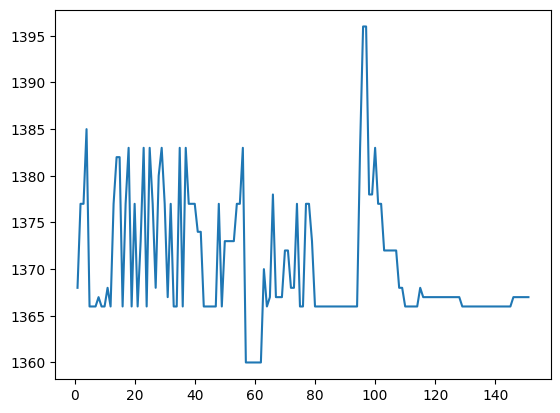

In [40]:
tai_inst = load_tai(20, 5)
hh = LSAGA(tai_inst[1],
           variety_degree=5,
           num_hyper_params_neigh_window=2, #numeric hyper-parameters neighboring window size
           cat_neigh_ratio=0.4,
           podium_banck_size=5)
hh.optim(T=1,
         T_min=0.001,
         alpha=0.9, # decay factor
         beta=100, # exploration factor
         nb_iter=150,
         length_palier=3,
         jump_rate=0.05,
         jump_ratio=1.15,
         trace=True)
print('make_span_star', hh.make_span_star)
print('hps_star', hh.hps_star)
print('nb_podium_bank_usage', hh.nb_podium_bank_usage)
print('nb_deteriorations', hh.nb_deteriorations)
print('nb_jumps', hh.nb_jumps)
plt.plot(range(1, len(hh.current_make_span_trace)+1), hh.current_make_span_trace)

Function to execute the neh, cds and palmer heuristics for comparison

In [ ]:
def exec_heur(instances):
    cds = []
    palmer = []
    neh = []
    for instance in instances:
        def get_instance(tai_inst:Inst):
                jobs_list = []
                for i in range(len(tai_inst.matrix[0])):
                    jobs_list.append([])
                    for j in range(len(tai_inst.matrix)):
                        jobs_list[-1].append(tai_inst.matrix[j][i])
                return jobs_list
        jobs_list = get_instance(instance)
        
        cds.append(heuristics.cds_heuristic(np.array(jobs_list))[1])
        
        palmer.append(heuristics.Palmer(jobs_list).optim()[1])

        neh.append(heuristics.NEH(instance)()[0])
        
    return cds, palmer, neh

Function to execute simulated annealing alone for comparison (with hyper param tuning)

In [ ]:
class SimulatedAnnealing:
    def __init__(self, tai_inst:Inst):
        def get_instance(tai_inst:Inst):
            jobs_list = []
            for i in range(len(tai_inst.matrix[0])):
                jobs_list.append([])
                for j in range(len(tai_inst.matrix)):
                    jobs_list[-1].append(tai_inst.matrix[j][i])
            return jobs_list
        self.tai_inst = tai_inst
        self.jobs_list = get_instance(tai_inst)
        self.nb_jobs = len(self.jobs_list)
        self.nb_machines = len(self.jobs_list[0])
        self.seq_star = None
        self.make_span_star = None

    # utility function that returns the gantt cumule based on a job execution times and a previous gantt cumule
    def cumulate(self, job:list, previous_cumul=None):
        res = [0] * len(job)

        if(previous_cumul==None):
            res[0] = job[0]
            for i in range(1, len(job)):
                res[i] = res[i-1] + job[i]
        else:
            res[0] = previous_cumul[0] + job[0]
            for i in range(1, len(job)):
                res[i] = max(res[i-1], previous_cumul[i]) + job[i]

        return res

    # utility function that computes the gantt cumule given only a job sequence (not used in the algorithm due to inneficiency
    # dynamic programming with cumulate is used instead ...)
    def cumulate_seq(self, seq:list):
        cumulated = None
        for i in seq:
            cumulated = self.cumulate(self. jobs_list[i], cumulated)
        return cumulated


    #launching the optimization
    def optim(self, debug=False, T=1.0, T_min=0.0001, alpha=0.9, nb_iter=10000, init_method='random', neigh_method='full', length_palier=1, jump_rate=0, jump_ratio=1.): 
        #making sure the jump ratio is not greater that the 1/alpha
        if jump_rate != 0 and jump_ratio>=1/alpha:
            raise Exception("Y_exception: jump_ratio >= 1/alpha")
        #initialize the current sequence and its make span
        if init_method == 'random':
            seq = np.random.choice(np.arange(0,self.nb_jobs), size=self.nb_jobs, replace=False)
            make_span = self.cumulate_seq(seq)[-1]
        elif init_method == 'palmer':
            palmer = heuristics.Palmer(self.jobs_list)
            seq, make_span = palmer.optim()
        elif init_method == 'cds':
            seq, make_span = heuristics.cds_heuristic(np.array(self.jobs_list))
        else:#neh
            make_span, seq = heuristics.NEH(self.tai_inst)()

        #initialize the iteration counter
        it = 1

        #initialize the best sequence and its make span
        self.seq_star = copy.deepcopy(seq)
        self.make_span_star = make_span

        #we initialize the temperature session at length_palier
        temp_session = length_palier
        #main loop
        while T > T_min and it<=nb_iter:
            #generate a random neighbour sequence
            if neigh_method == 'full':
                i, j = np.random.choice(np.arange(self.nb_jobs), size=2, replace=False)
                seq_neigh = copy.deepcopy(seq)
                seq_neigh[i], seq_neigh[j] = seq_neigh[j], seq_neigh[i]
            else:#next
                i = np.random.randint(0 , self.nb_jobs-1)
                seq_neigh = copy.deepcopy(seq)
                seq_neigh[i], seq_neigh[i+1] = seq_neigh[i+1], seq_neigh[i]
                
            #compute the make span of the neighbour sequence
            make_span_neigh = self.cumulate_seq(seq_neigh)[-1]

            #compute the energy difference
            delta = make_span - make_span_neigh

            #if the neighbour sequence is better, accept it
            if delta > 0:
                seq = copy.deepcopy(seq_neigh)
                make_span = make_span_neigh
                self.seq_star = copy.deepcopy(seq)
                self.make_span_star = make_span

            #if the neighbour sequence is worse, accept it with a probability that decreases with the temperature
            else:
                if random.random() < math.exp(delta/T):
                    seq = copy.deepcopy(seq_neigh)
                    make_span = make_span_neigh

            #cooling
            temp_session -= 1
            if temp_session == 0:
                if random.random() < jump_rate:
                    T = T * jump_ratio
                else:
                    T = T * alpha
                temp_session = length_palier

            #incrementing it
            it += 1
            
            #debug
            if debug:
                print("Iteration: ", it)
                print("Temperature: ", T)
                print("Sequence: ", seq)
                print("Make span: ", make_span)
            
        return self.make_span_star, self.seq_star

def exec_sa(instances, n_trials=10):

    studies = []
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    for i, instance in enumerate(instances):
        study = optuna.create_study()
        sa = SimulatedAnnealing(instance)
        
        def objective(trial):
            T = trial.suggest_float("T", 1, 10, step=1)
            T_min = trial.suggest_categorical("T_min", [0.001, 0.0001, 0.00001])
            alpha = trial.suggest_float("alpha", 0.5, 0.95, step=0.05)
            nb_iter = trial.suggest_categorical("nb_iter", [1000, 10000, 20000])
            init_method = trial.suggest_categorical("init_method", ['random', 'palmer', 'neh'])
            neigh_method = trial.suggest_categorical("neigh_method", ['full', 'next'])
            length_palier = trial.suggest_categorical("length_palier", [1, 5, 10, 20])
            jump_rate = trial.suggest_categorical("jump_rate", [0, 0.05, 0.1, 0.2])
            jump_ratio = trial.suggest_categorical("jump_ratio", [1.01, 1.03, 1.05])

            return sa.optim(alpha=alpha, T=T, T_min=T_min, nb_iter=nb_iter, init_method=init_method, neigh_method=neigh_method, length_palier=length_palier, jump_rate=jump_rate, jump_ratio=jump_ratio)[0]

        study.optimize(objective, n_trials, show_progress_bar=True)
        studies.append(copy.deepcopy(study))

    return studies

Function to execute the genetic algorithm for comparison (with hyper param tuning)

In [ ]:
class GeneticAlgorithm:
    def __init__(self, tai_inst: Inst):
        # Initializes the Genetic Algorithm with a given instance of the scheduling problem.
        
        self.tai_inst = tai_inst
        self.jobs_list = self.get_instance(tai_inst)
        self.nb_jobs = len(self.jobs_list)
        self.nb_machines = len(self.jobs_list[0])
        self.seq_star = None
        self.make_span_star = None

        
    def get_instance(self, tai_inst: Inst):
        # Extract the jobs list from the given instance
        
        jobs_list = []
        for i in range(len(tai_inst.matrix[0])):
            jobs_list.append([])
            for j in range(len(tai_inst.matrix)):
                jobs_list[-1].append(tai_inst.matrix[j][i])
        return jobs_list

    
    def cumulate(self, job: list, previous_cumul=None):
        # Calculate the cumulative completion times for a job
            
        res = [0] * len(job)
        if previous_cumul == None:
            res[0] = job[0]
            for i in range(1, len(job)):
                res[i] = res[i - 1] + job[i]
        else:
            res[0] = previous_cumul[0] + job[0]
            for i in range(1, len(job)):
                res[i] = max(res[i - 1], previous_cumul[i]) + job[i]
        return res

    
    def cumulate_seq(self, seq: list):
        # Calculates the cumulative time for a sequence of jobs on machines.

        cumulated = None
        for i in seq:
            cumulated = self.cumulate(self.jobs_list[i], cumulated)
        return cumulated

    
    def evaluate_makespan(self, schedule):
        # Evaluates the makespan (completion time) of a given schedule.

        cumulative = self.cumulate_seq(schedule)
        return cumulative[-1]

    
    def initialize_population(self, init_type, population_size):
        """
        Initializes the population of individuals.
        
        Args:
            init_type (str): Type of initialization method.
            population_size (int): Size of the population.
            
        Returns:
            list: Initialized population of individuals.
        """
        
        def perturb_sequence(sequence):
            """
            Perturbs a sequence by swapping two random jobs.
            
            Args:
                sequence (list): Sequence of jobs.
                
            Returns:
                list: Perturbed sequence.
            """
            perturbed_seq = sequence[:]
            for _ in range(2):
                i, j = random.sample(range(len(perturbed_seq)), 2)
                perturbed_seq[i], perturbed_seq[j] = perturbed_seq[j], perturbed_seq[i]
            return perturbed_seq

        population = []
        
        if init_type == "cds":
            cds_seq, _ = heuristics.cds_heuristic(np.array(self.jobs_list))
            population.append(cds_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(cds_seq)
                population.append(perturbed_seq)

        elif init_type == "palmer":
            palmer_seq, _ = heuristics.Palmer(self.jobs_list).optim()
            population.append(palmer_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(palmer_seq)
                population.append(perturbed_seq)

        elif init_type == "neh":
            _, neh_seq = heuristics.NEH(self.tai_inst)()
            population.append(neh_seq)
            for _ in range(population_size - 1):
                perturbed_seq = perturb_sequence(neh_seq)
                population.append(perturbed_seq)

        elif init_type == "heuristics":
            cds_size = population_size // 3
            palmer_size = population_size // 3
            neh_size = population_size - cds_size - palmer_size
            
            for _ in range(cds_size):
                cds_seq, _ = heuristics.cds_heuristic(np.array(self.jobs_list))
                population.append(perturb_sequence(cds_seq))
            
            for _ in range(palmer_size):
                palmer_seq, _ = heuristics.Palmer(self.jobs_list).optim()
                population.append(perturb_sequence(palmer_seq))
            
            for _ in range(neh_size):
                _, neh_seq = heuristics.NEH(self.tai_inst)()
                population.append(perturb_sequence(neh_seq))

        elif init_type == "heuristics_random":

            cds_seq, _ = heuristics.cds_heuristic(np.array(self.jobs_list))
            population.append(perturb_sequence(cds_seq))

            palmer_seq, _ = heuristics.Palmer(self.jobs_list).optim()
            population.append(perturb_sequence(palmer_seq))

            _, neh_seq = heuristics.NEH(self.tai_inst)()
            population.append(perturb_sequence(neh_seq))

            for _ in range(population_size - 3):
                random_seq = random.sample(range(self.nb_jobs), self.nb_jobs)
                population.append(random_seq)

        elif init_type == "full_random":

            for _ in range(population_size):
                random_seq = random.sample(range(self.nb_jobs), self.nb_jobs)
                population.append(random_seq)

        else:
            raise ValueError("Invalid initialization type")

        return population

    
    def select_parents(self, population):
        """
        Selects parents from the population using tournament selection.
        
        Args:
            population (list): Population of individuals.
            
        Returns:
            tuple: Pair of selected parents.
        """
        tournament = random.sample(population, 3)
        tournament.sort(key=lambda x: self.evaluate_makespan(x))
        return tournament[0], tournament[1]

    
    def crossover(self, crossover_type, parent1, parent2, crossover_rate, k_points=None):
        """
        Performs crossover between two parents to produce offspring.
        
        Args:
            crossover_type (str): Type of crossover operation.
            parent1 (list): First parent.
            parent2 (list): Second parent.
            crossover_rate (float): Rate of crossover.
            k (int, optional): Parameter for k-point crossover. Defaults to None.
            
        Returns:
            tuple: Pair of offspring.
        """

        def ensure_each_job_once(offspring):
            """
            Ensures each job appears exactly once in the offspring.
            
            Args:
                offspring (list): Offspring sequence.
            """
            # Ensure offspring contains each job exactly once
            job_count = {job: 0 for job in range(self.nb_jobs)}
            for job in offspring:
                job_count[job] += 1
            for i, job in enumerate(offspring):
                if job_count[job] > 1:
                    for swap_job, count in job_count.items():
                        if count == 0:
                            offspring[i] = swap_job
                            job_count[swap_job] += 1
                            job_count[job] -= 1
                            break

        if random.random() < crossover_rate:
            
            if crossover_type == 'uniform':
                k = None
                mask = [random.choice([0, 1]) for _ in range(len(parent1))]
                offspring1 = [gene1 if bit else gene2 for gene1, gene2, bit in zip(parent1, parent2, mask)]
                offspring2 = [gene1 if bit else gene2 for gene1, gene2, bit in zip(parent2, parent1, mask)]

            else:
                if k_points is None or k_points < 1:
                    raise ValueError("k must be >= 1 for one_point, two_points, and k_points crossovers")
                
                if k_points is not None and k_points >= self.nb_jobs:
                    raise ValueError("k in crossover must be less than the number of jobs")

                if ((crossover_type == 'one_point') or (k_points == 1)):
                    k = 1
                    points = [random.randint(1, len(parent1) - 1)]

                elif ((crossover_type == 'two_points') or (k_points == 2)):
                    k = 2
                    points = sorted(random.sample(range(1, len(parent1)), 2))

                elif crossover_type == 'k_points':
                    points = sorted(random.sample(range(1, len(parent1)), k_points))

                else:
                    raise ValueError("Invalid crossover type")

                offspring1, offspring2 = parent1[:], parent2[:]
                switch = False
                for i in range(len(parent1)):
                    if i in points:
                        switch = not switch
                    if switch:
                        offspring1[i], offspring2[i] = offspring2[i], offspring1[i]

            ensure_each_job_once(offspring1)
            ensure_each_job_once(offspring2)
            return offspring1, offspring2
        
        else:
            return parent1[:], parent2[:]


    def mutate(self, solution, mutation_rate):
        """
        Mutates a solution with a given mutation rate.
        
        Args:
            solution (list): Solution to mutate.
            mutation_rate (float): Rate of mutation.
            
        Returns:
            list: Mutated solution.
        """
        if random.random() < mutation_rate:
            i, j = random.sample(range(len(solution)), 2)
            solution[i], solution[j] = solution[j], solution[i]
        return solution


    def select_reproduction_pool(self, selection_type, population, pool_size):
        """
        Selects a pool of individuals for reproduction.
        
        Args:
            selection_type (str): Type of selection method.
            population (list): Population of individuals.
            pool_size (int): Size of the pool.
            
        Returns:
            list: Pool of selected individuals.
        """
        
        chosen = []

        if selection_type == "roulette":
            total_fitness = sum(self.evaluate_makespan(ind) for ind in population)
            selection_probs = [self.evaluate_makespan(ind) / total_fitness for ind in population]
            chosen = random.choices(population, weights=selection_probs, k=pool_size)

        elif selection_type == "rank":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            ranks = range(1, len(population_sorted) + 1)
            total_rank = sum(ranks)
            rank_weights = [rank / total_rank for rank in ranks]
            chosen = random.choices(population_sorted, weights=rank_weights, k=pool_size)

        elif selection_type == "elitist":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            chosen = population_sorted[:pool_size]

        elif selection_type == "tournament":
            for _ in range(pool_size):
                contenders = random.sample(population, 3)
                chosen.append(min(contenders, key=self.evaluate_makespan))

        elif selection_type == "random":
            chosen = random.sample(population, pool_size)
            
        else:
            raise ValueError("Invalid type")

        return chosen

    
    def replace_population(self, replacement_type, population, parents, offspring, population_size):
        """
        Replaces the population with new individuals.
        
        Args:
            replacement_type (str): Type of replacement method.
            population (list): Current population.
            parents (list): Parents generated during reproduction.
            offspring (list): Offspring generated during reproduction.
            population_size (int): Size of the population.
            
        Returns:
            list: New population.
        """
        
        def select_population(selection_type, population, pool_size):
            """
            Selects individuals for the next population.
            
            Args:
                selection_type (str): Type of selection method.
                population (list): Population of individuals.
                pool_size (int): Size of the selection pool.
                
            Returns:
                list: Selected individuals for the next population.
            """
            return self.select_reproduction_pool(selection_type, population, pool_size)

        if replacement_type == "best_all":
            combined_population = population + offspring
            combined_population.sort(key=lambda x: self.evaluate_makespan(x))
            return combined_population[:population_size]

        elif replacement_type == "parents_replaced_by_offspring":
            population_without_parents = [ind for ind in population if ind not in parents]
            return population_without_parents + offspring

        elif replacement_type == "worst_population_replaced_by_offspring":
            population_sorted = sorted(population, key=self.evaluate_makespan)
            population_without_worst = population_sorted[:-len(offspring)]
            return population_without_worst + offspring

        elif replacement_type == "best_between_parents_and_offspring":
            population_without_parents = [ind for ind in population if ind not in parents]
            combined_sub_population = sorted(parents + offspring, key=self.evaluate_makespan)
            return population_without_parents + combined_sub_population[:len(parents)]
        
        else:
            return select_population(replacement_type, population + offspring, len(population))
    

    def genetic_algorithm(self, init_type, selection_type, crossover_type, replacement_type, population_size, pool_size, crossover_rate, mutation_rate, num_iterations, max_stagnation, k_points=None):
        """
        Executes the Genetic Algorithm to find the best solution.
        
        Args:
            init_type (str): Type of initialization method.
            selection_type (str): Type of parent selection method.
            crossover_type (str): Type of crossover method.
            replacement_type (str): Type of population replacement method.
            population_size (int): Size of the population.
            pool_size (int): Size of the reproduction pool.
            crossover_rate (float): Rate of crossover.
            mutation_rate (float): Rate of mutation.
            num_iterations (int): Maximum number of iterations.
            max_stagnation (int): Maximum number of iterations without improvement.
            k_points (int, optional): Parameter for k-point crossover. Defaults to None.
            
        Returns:
            tuple: Best solution and its makespan.
        """
        
        if pool_size > population_size:
            raise ValueError("Pool size must be less than population size.")

        population = self.initialize_population(init_type, population_size)
        population.sort(key=lambda x: self.evaluate_makespan(x))
        
        best_solution = population[0]
        best_solution_fitness = self.evaluate_makespan(best_solution)
        stagnation_count = 0

        for i in range(num_iterations):
            reproduction_pool = self.select_reproduction_pool(selection_type, population, pool_size)
            offspring = []
            parents = []

            for _ in range(pool_size // 2):
                parent1, parent2 = self.select_parents(reproduction_pool)
                parents.extend([parent1, parent2])
                child1, child2 = self.crossover(crossover_type, parent1, parent2, crossover_rate, k_points) 
                child1 = self.mutate(child1, mutation_rate)
                child2 = self.mutate(child2, mutation_rate)
                offspring.extend([child1, child2])

            population = self.replace_population(replacement_type, population, parents, offspring, population_size)
            population.sort(key=lambda x: self.evaluate_makespan(x))

            current_best_solution = population[0]
            current_best_solution_fitness = self.evaluate_makespan(current_best_solution)

            if current_best_solution_fitness < best_solution_fitness:
                best_solution = current_best_solution
                best_solution_fitness = current_best_solution_fitness
                stagnation_count = 0
            else:
                stagnation_count += 1

            if max_stagnation is not None and stagnation_count >= max_stagnation:
                break

        return best_solution

    
    def fit(self, 
            init_type = 'heuristics', 
            selection_type = 'random', 
            crossover_type = 'one_point', 
            replacement_type = 'best_all', 
            population_size = 20, 
            pool_size = 15, 
            crossover_rate = 0.8, 
            mutation_rate = 0.1, 
            num_iterations = 200,
            max_stagnation = 10,
            k_points = 1
            ):
        
        self.seq_star = self.genetic_algorithm(init_type, selection_type, crossover_type, replacement_type, population_size, pool_size, crossover_rate, mutation_rate, num_iterations, max_stagnation, k_points)
        self.make_span_star = self.evaluate_makespan(self.seq_star)
        return self.make_span_star, self.seq_star
    

def exec_ga(instances, n_trials=10):
    studies = []
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    for i, instance in enumerate(instances):
        study = optuna.create_study()
        ga = GeneticAlgorithm(instance)
        def objective(trial):
            init_type = trial.suggest_categorical("init_type", ['cds', 'palmer', 'neh', 'heuristics', 'heuristics_random', 'full_random'])
            selection_type = trial.suggest_categorical("selection_type", ['roulette', 'rank', 'elitist', 'tournament', 'random'])
            crossover_type = trial.suggest_categorical("crossover_type", ['uniform', 'one_point', 'two_points', 'k_points'])
            replacement_type = trial.suggest_categorical("replacement_type", ['best_all', 'parents_replaced_by_offspring', 'worst_population_replaced_by_offspring', 'best_between_parents_and_offspring', 'roulette', 'rank', 'elitist', 'tournament', 'random'])     
            population_size = trial.suggest_int("population_size", 20, 50, step=10)
            pool_size = trial.suggest_int("pool_size", 10, 20, step=5)
            crossover_rate = trial.suggest_float("crossover_rate", 0.1, 0.9, step=0.1)
            mutation_rate = trial.suggest_float("mutation_rate", 0.1, 0.9, step=0.1)
            num_iterations = trial.suggest_int("num_iterations", 200, 1000, step=100)
            max_stagnation = trial.suggest_int("max_stagnation", 50, 200, step=50)
            k_points = trial.suggest_int("k_points", 1, 3, step=1)

            return ga.fit(init_type, selection_type, crossover_type, replacement_type, population_size, pool_size, crossover_rate, mutation_rate, num_iterations, max_stagnation, k_points)[0]

        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

        studies.append(copy.deepcopy(study))
    
    return studies

Function to compare the results

In [ ]:
css = [
        {'selector': '', 'props': [('min-width', '110px')]},
        {'selector': 'th', 'props': [('min-width', '110px')]}
      ]

def compare(instances, study_lsaga, study_ga, study_sa, cds, palmer, neh):

    def highlight(s):
        is_min = s == s.min()
        is_max = s == s.max()
        return ['color: green; font-weight: bold' if v else 'color: red; font-weight: bold' if w else '' for v, w in zip(is_min, is_max)]


    # Define the data
    instance_names = [f"Instance {i+1}" for i in range(len(instances))]

    data = {
                'LSAGA' : study_lsaga,
                'Genetic Algorithm' : [int(study.best_value) for study in study_ga],
                'Simmulated annealing' : [int(study.best_value) for study in study_sa],
                'CDS': cds,
                'Palmer': palmer,
                'NEH': neh,
                'Upper bound': [instance.ub for instance in instances]
           }

    df = pd.DataFrame(data)
    df.index = instance_names
    styled_df = df.style.apply(highlight, axis=1, subset=df.columns[:-1])
    return styled_df.set_table_styles(css)

# Algorithm execution

20 jobs 5 machines

In [ ]:
instances_20_5 = load_tai(20,5)
makes_spans_20_5 = []
for instance in instances_20_5:
    saga = LSAGA(instance, variety_degree=4)
    saga.optim(T_min=0.005)
    makes_spans_20_5.append(saga.make_span_star)

Temperature 0.011972515182562033:   8%|▊         | 42/500 [01:13<13:20,  1.75s/it]


KeyboardInterrupt: 

In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_20_5)
print("optuna tuning simulated annealing")
study_sa = exec_sa(instances_20_5)
print("optuna tuning genetic algorithm")
study_ga = exec_ga(instances_20_5)

executing heursitics
tuning simulated annealing


Best trial: 3. Best value: 1130: 100%|██████████| 10/10 [00:00<00:00, 37.69it/s]


tuning genetic algorithm


Best trial: 4. Best value: 1120: 100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


In [ ]:
compare(instances_20_5, makes_spans_20_5, study_ga, study_sa, cds, palmer, neh)

,LSAGA,Genetic Algorithm,Simmulated annealing,CDS,Palmer,NEH,Upper bound
Instance 1,1279,1297,1297,1422,1384,1334,1278
Instance 2,1360,1366,1368,1424,1439,1377,1359
Instance 3,1096,1098,1098,1255,1162,1157,1081
Instance 4,1304,1302,1307,1418,1420,1402,1293
Instance 5,1250,1250,1250,1323,1360,1319,1236
Instance 6,1210,1224,1210,1312,1344,1342,1195
Instance 7,1251,1251,1251,1393,1400,1268,1239
Instance 8,1211,1218,1211,1345,1290,1262,1206
Instance 9,1253,1255,1254,1360,1426,1346,1230
Instance 10,1114,1120,1130,1164,1229,1227,1108


20 jobs 10 machines

In [ ]:
instances_20_10 = load_tai(20,10)
makes_spans_20_10 = []
for instance in instances_20_10:
    saga = LSAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_20_10.append(saga.make_span_star)

Temperature 0.01077526366430583:   9%|▊         | 43/500 [02:36<27:40,  3.63s/it]  


In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_20_10)
print("tuning simulated annealing")
study_sa = exec_sa(instances_20_10)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_20_10)

executing heursitics
tuning simulated annealing


Best trial: 1. Best value: 1652: 100%|██████████| 10/10 [00:00<00:00, 34.71it/s]


tuning genetic algorithm


Best trial: 4. Best value: 1631: 100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


In [ ]:
compare(instances_20_10, makes_spans_20_10, study_ga, study_sa, cds, palmer, neh)

,LSAGA,Genetic Algorithm,Simmulated annealing,CDS,Palmer,NEH,Upper bound
Instance 1,1621,1600,1637,1757,1790,1675,1582
Instance 2,1707,1703,1717,1854,1948,1797,1659
Instance 3,1540,1548,1554,1661,1729,1567,1496
Instance 4,1397,1422,1443,1547,1585,1551,1378
Instance 5,1444,1475,1471,1558,1648,1479,1419
Instance 6,1427,1433,1434,1591,1527,1509,1397
Instance 7,1503,1493,1525,1630,1735,1593,1484
Instance 8,1571,1588,1606,1766,1763,1688,1538
Instance 9,1631,1611,1659,1720,1836,1659,1593
Instance 10,1631,1631,1652,1884,1898,1702,1591


20 jobs 20 machines

In [ ]:
instances_20_20 = load_tai(20,20)
makes_spans_20_20 = []
for instance in instances_20_20:
    saga = LSAGA(instance, variety_degree=5)
    saga.optim(T_min=0.005)
    makes_spans_20_20.append(saga.make_span_star)

Temperature 0.00515377520732012:  10%|█         | 50/500 [05:01<45:17,  6.04s/it]   


In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_20_20)
print("tuning simulated annealing")
study_sa = exec_sa(instances_20_20)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_20_20)

executing heursitics
tuning simulated annealing


Best trial: 5. Best value: 2268: 100%|██████████| 10/10 [00:00<00:00, 12.57it/s]


tuning genetic algorithm


Best trial: 5. Best value: 2252: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]


In [ ]:
compare(instances_20_20, makes_spans_20_20, study_ga, study_sa, cds, palmer, neh)

,LSAGA,Genetic Algorithm,Simmulated annealing,CDS,Palmer,NEH,Upper bound
Instance 1,2334,2359,2363,2579,2818,2456,2297
Instance 2,2136,2138,2147,2285,2331,2197,2100
Instance 3,2360,2397,2388,2565,2678,2493,2326
Instance 4,2257,2269,2294,2415,2629,2316,2223
Instance 5,2327,2345,2352,2506,2704,2436,2291
Instance 6,2270,2303,2289,2422,2572,2364,2226
Instance 7,2322,2334,2339,2489,2456,2406,2273
Instance 8,2226,2226,2240,2362,2435,2278,2200
Instance 9,2255,2264,2284,2409,2754,2399,2237
Instance 10,2212,2252,2268,2439,2633,2352,2178


50 jobs 5 machines

In [ ]:
instances_50_5 = load_tai(50,5)
makes_spans_50_5 = []
for instance in instances_50_5:
    saga = LSAGA(instance, variety_degree=5)
    saga.optim(T_min=0.005)
    makes_spans_50_5.append(saga.make_span_star)

Temperature 0.00515377520732012:  10%|█         | 50/500 [03:40<33:07,  4.42s/it]  


In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_50_5)
print("tuning simulated annealing")
study_sa = exec_sa(instances_50_5)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_50_5)

executing heursitics
tuning simulated annealing


Best trial: 0. Best value: 2815: 100%|██████████| 10/10 [00:01<00:00,  8.51it/s]


tuning genetic algorithm


Best trial: 9. Best value: 2783: 100%|██████████| 10/10 [00:54<00:00,  5.45s/it]


In [ ]:
compare(instances_50_5, makes_spans_50_5, study_ga, study_sa, cds, palmer, neh)

,LSAGA,Genetic Algorithm,Simmulated annealing,CDS,Palmer,NEH,Upper bound
Instance 1,2735,2735,2735,2883,2774,2745,2724
Instance 2,2848,2863,2890,3032,3014,2943,2834
Instance 3,2624,2630,2648,2714,2777,2712,2621
Instance 4,2770,2778,2802,2884,2860,2855,2751
Instance 5,2864,2864,2891,3038,2963,2929,2863
Instance 6,2831,2835,2849,3031,3090,2938,2829
Instance 7,2732,2738,2746,2978,2845,2800,2725
Instance 8,2700,2705,2707,2867,2826,2795,2683
Instance 9,2568,2568,2592,2784,2733,2683,2552
Instance 10,2782,2783,2815,3000,2915,2878,2782


50 jobs 10 machines

In [ ]:
instances_50_10 = load_tai(50,10)
makes_spans_50_10 = []
for instance in instances_50_10:
    saga = LSAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_50_10.append(saga.make_span_star)

Temperature 0.01077526366430583:   9%|▊         | 43/500 [08:00<1:25:07, 11.18s/it] 


In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_50_10)
print("tuning simulated annealing")
study_sa = exec_sa(instances_50_10)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_50_10)

executing heursitics
tuning simulated annealing


Best trial: 6. Best value: 3195: 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


tuning genetic algorithm


Best trial: 9. Best value: 3182: 100%|██████████| 10/10 [02:29<00:00, 14.90s/it]


In [ ]:
compare(instances_50_10, makes_spans_50_10, study_ga, study_sa, cds, palmer, neh)

,LSAGA,Genetic Algorithm,Simmulated annealing,CDS,Palmer,NEH,Upper bound
Instance 1,3096,3151,3186,3382,3461,3249,3025
Instance 2,2987,2972,3014,3263,3313,3145,2892
Instance 3,2936,2984,2957,3287,3335,3125,2864
Instance 4,3135,3137,3192,3393,3511,3214,3064
Instance 5,3072,3066,3183,3375,3427,3222,2986
Instance 6,3079,3118,3158,3400,3318,3246,3006
Instance 7,3175,3197,3232,3530,3457,3270,3107
Instance 8,3104,3106,3144,3371,3382,3219,3039
Instance 9,2982,2994,2978,3251,3414,3096,2902
Instance 10,3169,3182,3195,3429,3404,3223,3091


# Partial Conclusion

From these first 5 configurations studies, it appears that our proposed hyper heuristic shows promising results as it has often outperformed the other heuristics for the different instances. We can also notice that for the instances where it didn't perform as the best algorithm, it still ranked pretty well in the overall ranking.

These results seem to encourage the idea of using a simulated annealing meta heuristic for the top level with a learning mecanism for the neighbor selection during exploration as proposed in our method. But still, further exploration with the rest of the taillard configurations remains necessary to fully asses tha quality of our solution. 

Also, as during these demos the hyper-parameters of the top level weren't fine tuned (as it would have taken more time than allowed for this first study), it seems reasonable to expect a significant improvement if the simulated annealing hyper-parameters were studied more thoroughly, especially for the variety-degree hyper-parameter (the minimum number of dimensions in the GA hyper-parameters space to change at neighbor generation) and the length_palier hyper-parameter (the number of iterations during which the temperature remains constant, by default =1).

---
50 jobs 20 machines

In [ ]:
instances_50_20 = load_tai(50,20)
makes_spans_50_20 = []
for instance in instances_50_20:
    saga = LSAGA(instance, variety_degree=5)
    saga.optim(T_min=0.01)
    makes_spans_50_20.append(saga.make_span_star)
with open("lsaga_makes_spans_50_20.txt","w") as f:
    for make_span in makes_spans_50_20:
        f.write(str(make_span)+'\n')

Temperature 0.01077526366430583:   9%|▊         | 43/500 [04:24<46:51,  6.15s/it]   


In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_50_20)
print("tuning simulated annealing")
study_sa = exec_sa(instances_50_20)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_50_20)

executing heursitics
tuning simulated annealing


Best trial: 0. Best value: 3982: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


tuning genetic algorithm


Best trial: 7. Best value: 3916: 100%|██████████| 10/10 [05:46<00:00, 34.64s/it]


In [ ]:
compare(instances_50_20, makes_spans_50_20, study_ga, study_sa, cds, palmer, neh)

,LSAGA,Genetic Algorithm,Simmulated annealing,CDS,Palmer,NEH,Upper bound
Instance 1,4036,4053,4091,4319,4272,4164,3875
Instance 2,3914,3952,4007,4216,4303,4020,3715
Instance 3,3866,3866,3877,4203,4210,3877,3668
Instance 4,3908,3960,4006,4256,4233,4063,3752
Instance 5,3801,3841,3851,4180,4376,3878,3635
Instance 6,3873,3890,3910,4238,4312,3957,3698
Instance 7,3921,3888,3945,4134,4306,3988,3716
Instance 8,3942,3891,4035,4283,4318,4064,3709
Instance 9,3921,3953,3999,4219,4547,4022,3765
Instance 10,3919,3916,3982,4264,4197,3991,3777


---
100 jobs 5 machines

In [ ]:
instances_100_5 = load_tai(100,5)
makes_spans_100_5 = []
for instance in instances_100_5:
    saga = LSAGA(instance, variety_degree=5)
    saga.optim(T_min=0.01)
    makes_spans_100_5.append(saga.make_span_star)
with open("lsaga_makes_spans_100_5.txt","w") as f:
    for make_span in makes_spans_50_20:
        f.write(str(make_span)+'\n')

Temperature 0.01077526366430583:   9%|▊         | 43/500 [03:55<41:44,  5.48s/it]   


In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_100_5)
print("tuning simulated annealing")
study_sa = exec_sa(instances_100_5)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_100_5)

executing heursitics
tuning simulated annealing


Best trial: 3. Best value: 5347: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


tuning genetic algorithm


Best trial: 7. Best value: 5367: 100%|██████████| 10/10 [01:12<00:00,  7.24s/it]


In [ ]:
compare(instances_100_5, makes_spans_100_5, study_ga, study_sa, cds, palmer, neh)

,LSAGA,Genetic Algorithm,Simmulated annealing,CDS,Palmer,NEH,Upper bound
Instance 1,5493,5493,5505,5602,5749,5538,5493
Instance 2,5299,5316,5316,5548,5316,5379,5268
Instance 3,5212,5221,5287,5452,5325,5306,5175
Instance 4,5032,5043,5044,5273,5049,5114,5014
Instance 5,5267,5255,5311,5484,5317,5328,5250
Instance 6,5140,5145,5174,5203,5274,5200,5135
Instance 7,5283,5283,5305,5561,5376,5351,5246
Instance 8,5137,5144,5148,5387,5263,5204,5106
Instance 9,5487,5492,5506,5758,5606,5588,5454
Instance 10,5338,5367,5347,5708,5427,5388,5328


---
100 jobs 10 machines

In [ ]:
instances_100_10 = load_tai(100,10)
makes_spans_100_10 = []
for instance in instances_100_10:
    saga = LSAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_100_10.append(saga.make_span_star)

Temperature 0.01077526366430583:   9%|▊         | 43/500 [08:12<1:27:16, 11.46s/it] 


In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_100_10)
print("tuning simulated annealing")
study_sa = exec_sa(instances_100_10)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_100_10)

executing heursitics
tuning simulated annealing


Best trial: 8. Best value: 5987: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


tuning genetic algorithm


Best trial: 2. Best value: 5959: 100%|██████████| 10/10 [02:04<00:00, 12.44s/it]


In [ ]:
compare(instances_100_10, makes_spans_100_10, study_ga, study_sa, cds, palmer, neh)

,LSAGA,Genetic Algorithm,Simmulated annealing,CDS,Palmer,NEH,Upper bound
Instance 1,5887,5885,5955,6198,6161,6027,5770
Instance 2,5428,5503,5536,5851,5889,5569,5349
Instance 3,5764,5781,5803,6029,6119,5857,5677
Instance 4,5878,5966,6015,6408,6329,6044,5791
Instance 5,5670,5636,5766,6018,6070,5807,5468
Instance 6,5395,5409,5383,5751,5870,5508,5303
Instance 7,5706,5744,5744,6202,6442,5744,5599
Instance 8,5750,5776,5881,6146,6168,5938,5623
Instance 9,5979,5979,6014,6349,6081,6089,5875
Instance 10,5962,5959,5987,6439,6259,6022,5845


---
200 jobs 10 machines

In [ ]:
instances_200_10 = load_tai(200,10)
makes_spans_200_10 = []
for instance in instances_200_10:
    saga = LSAGA(instance, variety_degree=5)
    saga.optim(T_min=0.01)
    makes_spans_200_10.append(saga.make_span_star)

Temperature 0.38742048900000015:   2%|▏         | 9/500 [08:27<7:41:04, 56.34s/it]


KeyboardInterrupt: 

In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_200_10)
print("tuning simulated annealing")
study_sa = exec_sa(instances_200_10)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_200_10)

---
200 jobs 20 machines

In [ ]:
instances_200_20 = load_tai(200,20)
makes_spans_200_20 = []
for instance in instances_20_20:
    saga = LSAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_200_20.append(saga.make_span_star)

In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_200_20)
print("tuning simulated annealing")
study_sa = exec_sa(instances_200_20)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_200_20)

---
500 jobs 20 machines

In [ ]:
instances_500_20 = load_tai(500,20)
makes_spans_500_20 = []
for instance in instances_500_20:
    saga = LSAGA(instance, variety_degree=3)
    saga.optim(T_min=0.01)
    makes_spans_500_20.append(saga.make_span_star)

In [ ]:
print("executing heursitics")
cds, palmer, neh = exec_heur(instances_500_20)
print("tuning simulated annealing")
study_sa = exec_sa(instances_500_20)
print("tuning genetic algorithm")
study_ga = exec_ga(instances_500_20)

# High level hyper-parameter study

In [ ]:
def tune_saga(instances, n_trials=10):

    studies = []
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    for i, instance in enumerate(instances):
        study = optuna.create_study()
        
        def objective(trial):
            variety_degree = trial.suggest_categorical("variety_degree",[0, 1, 3, 5, 8])
            lsaga = LSAGA(instance,
                       variety_degree=variety_degree)
            
            lsaga.optim()
            return saga.make_span_star
        
        study.optimize(objective, n_trials, show_progress_bar=True)
        studies.append(copy.deepcopy(study))

    return studies

In [ ]:
instances = load_tai(20,5)
lsaga = LSAGA(instances[8], variety_degree=10)
lsaga.optim()
print(lsaga.make_span_star)

Temperature 0.0010611166119964739:  13%|█▎        | 65/500 [02:35<17:17,  2.39s/it]

1253
